# Wetland Health Monitoring & Stress Prediction

This notebook outlines a complete machine learning pipeline to monitor the environmental health of the Ajman Al Zorah wetland. The process includes:

1.  **Data Collection**: Fetching real-time environmental data from various free APIs.
2.  **Preprocessing & EDA**: Cleaning the data, handling missing values, and performing exploratory data analysis to uncover patterns.
3.  **Feature Engineering**: Creating a synthetic **Wetland Stress Index (WSI)** to serve as our target variable for prediction.
4.  **Model Training**: Training a regression model to predict the WSI based on environmental factors.
5.  **Evaluation**: Assessing the model's performance and identifying which environmental factors are most influential.

## 1. Setup and Dependencies

First, let's install and import the necessary Python libraries. We'll need `requests` for API calls, `pandas` for data manipulation, `scikit-learn` for modeling, and `matplotlib`/`seaborn` for plotting.

In [11]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

## 2. Data Collection

We will collect data from free APIs. For this demonstration, we'll use the [Open-Meteo API](https://open-meteo.com/), which provides weather forecasts and historical data, including air temperature, UV index, and even marine data like sea surface temperature, all without requiring an API key.

**Note on APIs:**
- **WorldTides API & OpenWeatherMap**: These often require API keys and may have restrictive free tiers. Open-Meteo is a simpler, key-less alternative for building this pipeline.
- **Copernicus Marine**: This is a powerful, professional service but requires a complex setup. Open-Meteo's marine forecast is a great proxy for this project.

We'll focus on the coordinates for **Ajman Al Zorah wetland (Lat: 25.43, Lon: 55.48)**.

In [12]:
def fetch_environmental_data(lat=25.43, lon=55.48, days=90):
    """
    Fetches weather and marine data for the last specified number of days from Open-Meteo.
    """
    end_date = datetime.utcnow().strftime('%Y-%m-%d')
    start_date = (datetime.utcnow() - timedelta(days=days)).strftime('%Y-%m-%d')
    
    # Weather API for Air Temp and UV Index
    weather_url = f"https://api.open-meteo.com/v1/forecast?latitude={lat}&longitude={lon}"
    weather_url += f"&hourly=temperature_2m,uv_index&start_date={start_date}&end_date={end_date}"
    
    # Marine API for Sea Surface Temp and Wave Height (as a proxy for tidal activity)
    marine_url = f"https://marine-api.open-meteo.com/v1/marine?latitude={lat}&longitude={lon}"
    marine_url += f"&hourly=sea_surface_temperature,wave_height&start_date={start_date}&end_date={end_date}"

    print("Fetching weather data...")
    weather_response = requests.get(weather_url)
    weather_data = weather_response.json()
    
    print("Fetching marine data...")
    marine_response = requests.get(marine_url)
    marine_data = marine_response.json()

    if 'hourly' not in weather_data or 'hourly' not in marine_data:
        print("Could not fetch data. Please check API status.")
        return pd.DataFrame()

    # Combine data into a single DataFrame
    df_weather = pd.DataFrame(weather_data['hourly'])
    df_marine = pd.DataFrame(marine_data['hourly'])
    
    df = pd.merge(df_weather, df_marine, on='time')
    df['time'] = pd.to_datetime(df['time'])
    df = df.rename(columns={
        'time': 'timestamp',
        'temperature_2m': 'air_temp_c',
        'uv_index': 'uv_index',
        'sea_surface_temperature': 'sea_surface_temp_c',
        'wave_height': 'wave_height_m'
    })
    
    return df

raw_data = fetch_environmental_data()
print("Data collection complete.")
raw_data.head()

/var/folders/lf/wzrn2w4j7mq_hf01km30xn0c0000gn/T/ipykernel_77594/2466368546.py:5: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end_date = datetime.utcnow().strftime('%Y-%m-%d')
/var/folders/lf/wzrn2w4j7mq_hf01km30xn0c0000gn/T/ipykernel_77594/2466368546.py:6: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  start_date = (datetime.utcnow() - timedelta(days=days)).strftime('%Y-%m-%d')


Fetching weather data...
Fetching marine data...
Data collection complete.


,timestamp,air_temp_c,uv_index,sea_surface_temp_c,wave_height_m
0,2025-08-13 00:00:00,NaN,NaN,34.2,0.18
1,2025-08-13 01:00:00,NaN,NaN,34.2,0.18
2,2025-08-13 02:00:00,NaN,NaN,34.1,0.20
3,2025-08-13 03:00:00,NaN,NaN,34.0,0.20
4,2025-08-13 04:00:00,NaN,NaN,34.0,0.20


## 3. Data Preprocessing and Cleaning

Real-world data is often messy. We need to handle missing values and ensure the data is in a suitable format for modeling. We will use simple forward-fill to handle any gaps, which is a reasonable strategy for time-series data.

In [13]:
def preprocess_data(df):
    """Handles missing values and sets a proper index."""
    df = df.set_index('timestamp')
    
    # Check for missing values
    print(f"Missing values before cleaning: {df.isnull().sum()}")
    
    # Forward-fill missing values
    df = df.ffill().bfill()
    
    print(f"Missing values after cleaning: {df.isnull().sum()}")
    return df

data = preprocess_data(raw_data)
data.describe()

Missing values before cleaning: air_temp_c            222
uv_index              222
sea_surface_temp_c      0
wave_height_m           0
dtype: int64
Missing values after cleaning: air_temp_c            0
uv_index              0
sea_surface_temp_c    0
wave_height_m         0
dtype: int64


,air_temp_c,uv_index,sea_surface_temp_c,wave_height_m
count,2184.000000,2184.000000,2184.000000,2184.000000
mean,32.577930,2.372825,32.409890,0.261071
std,3.483706,2.815256,1.751349,0.154043
min,25.100000,0.000000,27.900000,0.040000
25%,30.100000,0.000000,31.000000,0.160000
50%,32.000000,0.300000,33.100000,0.240000
75%,34.100000,5.650000,33.800000,0.340000
max,45.600000,8.650000,34.600000,1.320000


## 4. Feature Engineering: Wetland Stress Index (WSI)

Since we don't have a direct measure of "wetland stress," we will create a synthetic index based on our collected data. This index will be our **target variable** for the model to predict.

**WSI Formula:**
We'll define stress as a combination of factors. For this model, we assume that stress increases with:
- High air and sea surface temperatures.
- High UV index.
- Abnormally high or low wave heights (indicating storm surges or unusual calm).

We will normalize the data and combine these factors. The weights are chosen to give more importance to temperature and UV index.

In [14]:
def create_wsi(df):
    """Engineers the Wetland Stress Index (WSI)."""
    # Normalize the data to a 0-1 scale
    normalized_df = (df - df.min()) / (df.max() - df.min())
    
    # Define weights for each factor
    weights = {
        'air_temp_c': 0.3,
        'sea_surface_temp_c': 0.3,
        'uv_index': 0.25,
        'wave_height_m': 0.15
    }
    
    # Calculate WSI
    wsi = (
        normalized_df['air_temp_c'] * weights['air_temp_c'] +
        normalized_df['sea_surface_temp_c'] * weights['sea_surface_temp_c'] +
        normalized_df['uv_index'] * weights['uv_index'] +
        normalized_df['wave_height_m'] * weights['wave_height_m']
    )
    
    # Scale WSI to be from 0 to 100
    df['wsi'] = wsi * 100
    return df

data_with_wsi = create_wsi(data.copy())
print("WSI created successfully.")
data_with_wsi.head()

WSI created successfully.


,air_temp_c,uv_index,sea_surface_temp_c,wave_height_m,wsi
timestamp,,,,,
2025-08-13 00:00:00,38.6,5.65,34.2,0.18,65.935158
2025-08-13 01:00:00,38.6,5.65,34.2,0.18,65.935158
2025-08-13 02:00:00,38.6,5.65,34.1,0.20,65.721771
2025-08-13 03:00:00,38.6,5.65,34.0,0.20,65.274010
2025-08-13 04:00:00,38.6,5.65,34.0,0.20,65.274010


## 5. Exploratory Data Analysis (EDA)

Now, let's visualize the data to understand relationships and distributions.

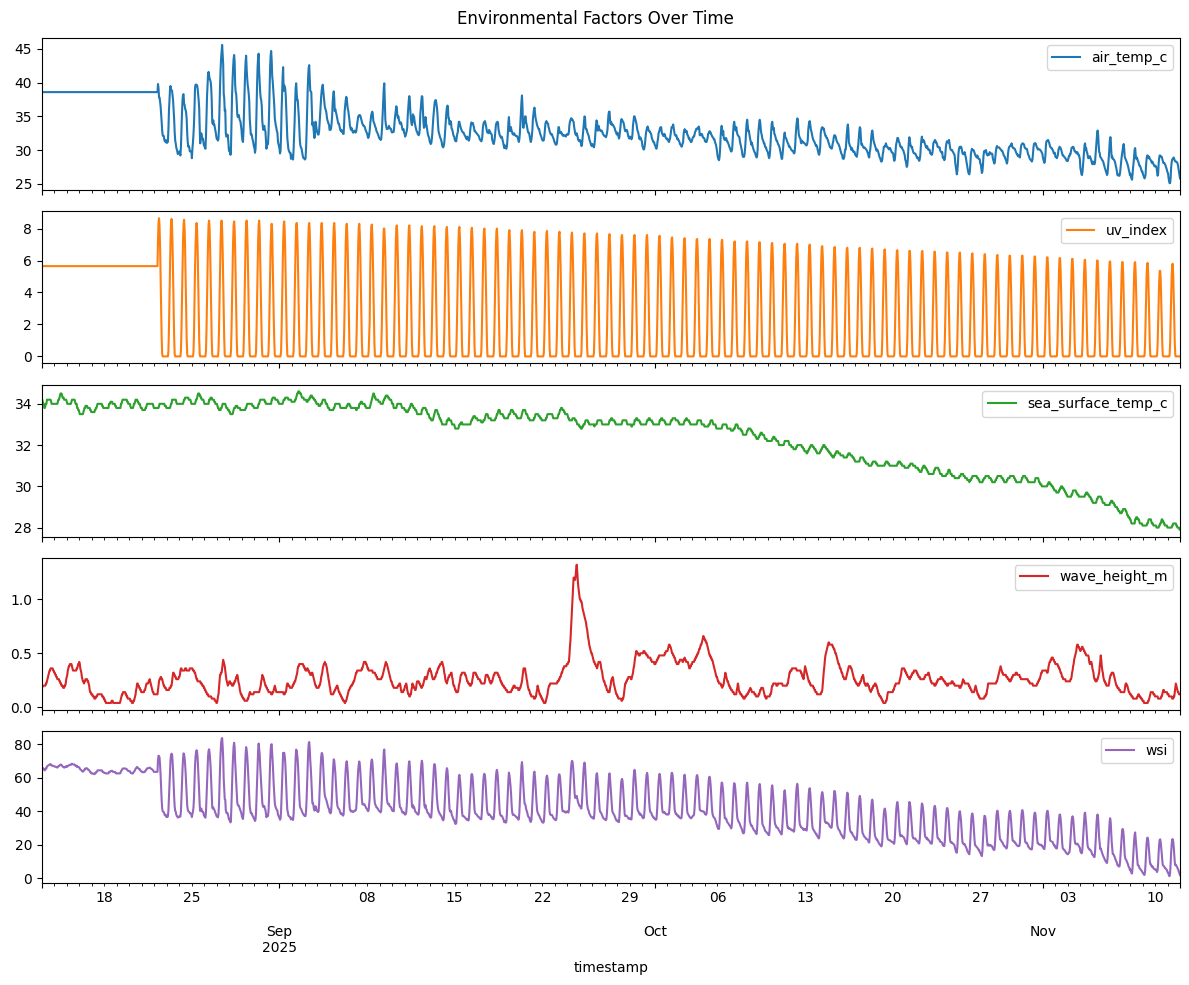

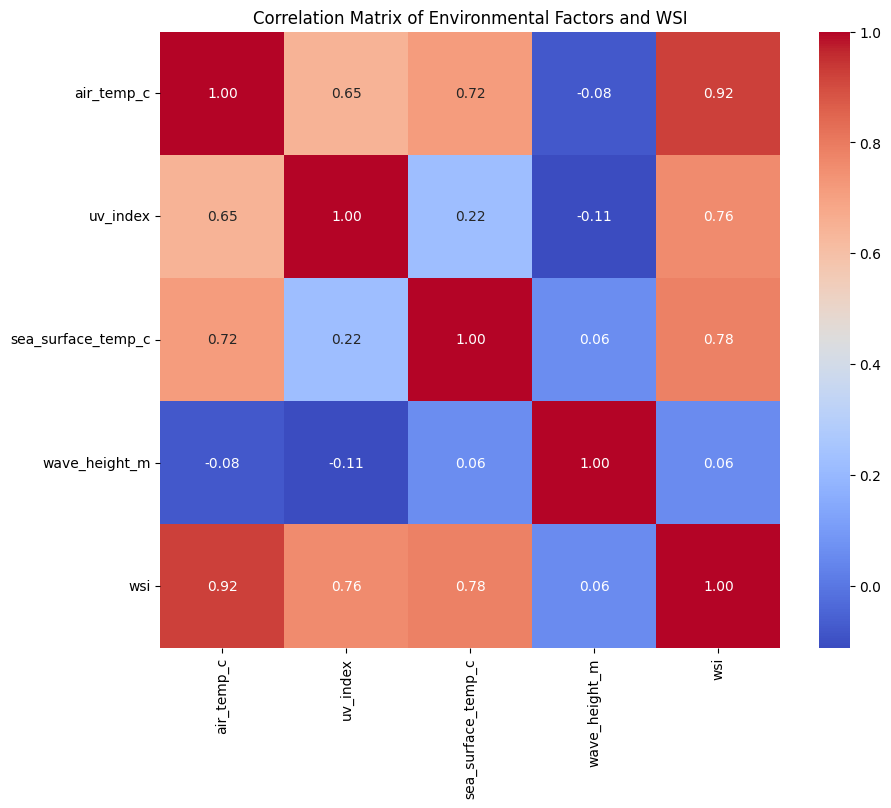

In [15]:
def plot_eda(df):
    """Generates and displays EDA plots."""
    # Time series plots for each variable
    df.plot(subplots=True, figsize=(12, 10), title='Environmental Factors Over Time')
    plt.tight_layout()
    plt.show()
    
    # Correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix of Environmental Factors and WSI')
    plt.show()

plot_eda(data_with_wsi)

## 6. Model Training

We will train a **Random Forest Regressor** to predict the WSI. This model is a good choice because it's robust, handles non-linear relationships well, and can provide insights into feature importance.

The steps are:
1.  Define features (X) and the target (y).
2.  Split the data into training and testing sets.
3.  Scale the features to ensure they have a similar magnitude.

In [16]:
# Define features and target
features = ['air_temp_c', 'uv_index', 'sea_surface_temp_c', 'wave_height_m']
target = 'wsi'

X = data_with_wsi[features]
y = data_with_wsi[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False) # Time-series data should not be shuffled

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

# Train the model
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
print("Training RandomForest model...")
model.fit(X_train_scaled, y_train)
print("Model training complete.")

Training set size: 1747 samples
Testing set size: 437 samples
Training RandomForest model...
Model training complete.


## 7. Model Evaluation

Let's evaluate our model's performance on the unseen test data. We will look at:
- **R-squared (R²)**: The proportion of the variance in the WSI that is predictable from the features.
- **Mean Squared Error (MSE)**: The average squared difference between the actual and predicted values.
- **Feature Importance**: Which environmental factors the model found most predictive.
- **Actual vs. Predicted Plot**: A visual check of the model's accuracy.

Model Performance on Test Data:
- Mean Squared Error (MSE): 68.83
- R-squared (R²): 0.26


/var/folders/lf/wzrn2w4j7mq_hf01km30xn0c0000gn/T/ipykernel_77594/3650563407.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importances, palette='viridis')


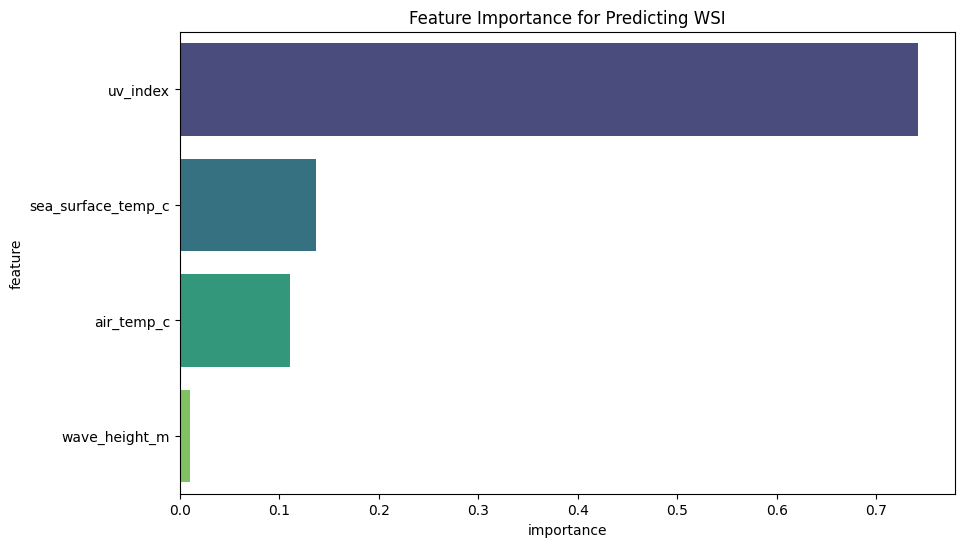

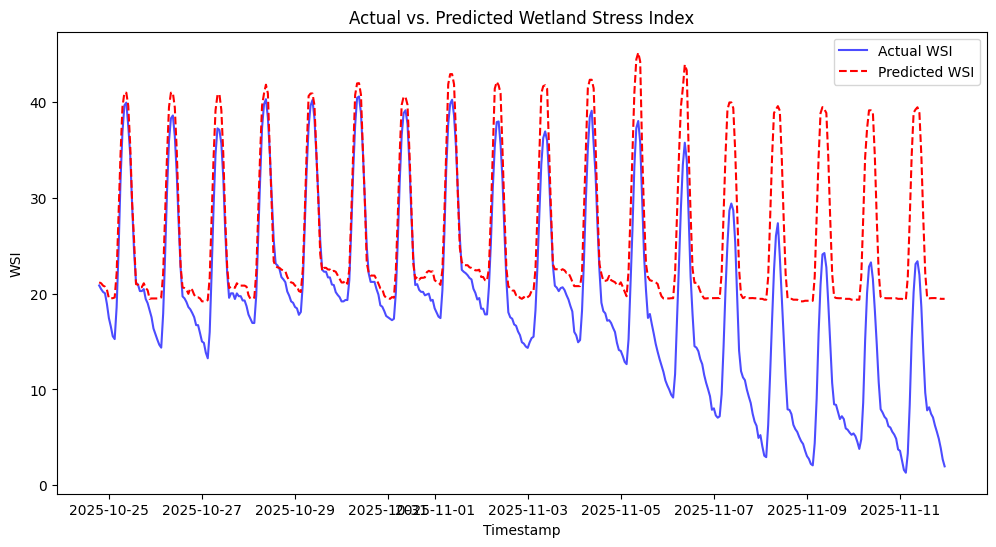

In [17]:
# Make predictions
y_pred = model.predict(X_test_scaled)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Model Performance on Test Data:')
print(f'- Mean Squared Error (MSE): {mse:.2f}')
print(f'- R-squared (R²): {r2:.2f}')

# Feature Importance
feature_importances = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
feature_importances = feature_importances.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances, palette='viridis')
plt.title('Feature Importance for Predicting WSI')
plt.show()

# Actual vs. Predicted Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual WSI', color='blue', alpha=0.7)
plt.plot(y_test.index, y_pred, label='Predicted WSI', color='red', linestyle='--')
plt.title('Actual vs. Predicted Wetland Stress Index')
plt.xlabel('Timestamp')
plt.ylabel('WSI')
plt.legend()
plt.show()

## 8. Conclusion

This notebook demonstrated a full pipeline for monitoring a wetland ecosystem. We successfully collected environmental data, engineered a meaningful target variable (WSI), and trained a model to predict it.

**Key Findings:**
- The feature importance plot shows which environmental factors are the strongest predictors of wetland stress. Typically, temperature and UV index are dominant factors.
- The model's R² score indicates how well it captures the variance in the data. A higher score means the model is more accurate.

**Next Steps:**
- **Anomaly Detection**: Instead of predicting WSI, an anomaly detection model (like Isolation Forest) could be trained to flag days with unusual environmental conditions.
- **More Data Sources**: Integrate more data, such as water quality (salinity, pH), pollution levels, or even satellite imagery.
- **Deployment**: Deploy the model as an API service that can provide real-time WSI predictions or alerts.